In [1]:
%pylab inline
import numpy as np
import pandas as pd
import os, sys
import random
import networkx as nx
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import SAD as sad

# Setup of (S)AD creation

We create here a set of activity values for N nodes, so that we will be able to assign them to the nodes later.

0.011462180106982092 0.00032089483038520434


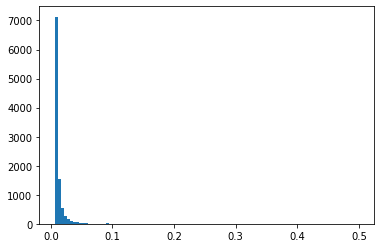

In [3]:
# We create activity values for N nodes. I choose it big so later I can 
# take n<N nodes and already have the activities (this is just for laziness)
N = 10000 

# produce activities, I use here a pareto, but could be anything. 
from scipy.stats import norm,pareto
b = 2.1
dist = pareto(b).rvs(100000)
dist = np.random.choice(dist,N)
act = dict(zip(range(N),dist/(2.0*np.max(dist))))
plt.hist(list(act.values()),100)
mu, v  = np.mean(list(act.values())), np.mean(np.array(list(act.values()))**2)
print(mu, v)

# Creation of a memoryless graph

I pick a maximal time to run the model $T$ and a fixed dimension for the simplices to add $k$. 
I also choose a time $T_{agg}<T$ for the aggregated graph (from 0 to $T_{agg}$)

In [4]:
n = 200
T = 500 
k = 4
Tagg = 499;

If I just give $k$ as a scalar, the code below generates the temporal network using only k-dimensional simplices. Below I generate both a SAD and the corresponding AD model with matched density. 

In [5]:
SadTG, fh = sad.temporal_graph_creation(n,T,k,act,mode='simplicial',returnhist=True);
# the temporal generation can already return the full history of interactions, if you need it.
# for us however, we will just ignore it here, since you only need the instant graph for the
# avalanche
SadTGa = sad.aggregate_graph(SadTG,Tagg)

tot = []
for t in fh:
    tot.extend(map(len,fh[t]))
krenorm = int(round(sad.invert_k(np.mean(list(map(lambda x: x*(x-1)/2, tot))))))

AdTG = sad.temporal_graph_creation(n,T,krenorm,act,mode='network')
AdTGa = sad.aggregate_graph(AdTG,Tagg) 

Then you can do what you want with the graphs. Each temporal graphs comes out as a dictionary keyed by time with a graph for each item. 

/home/petri/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


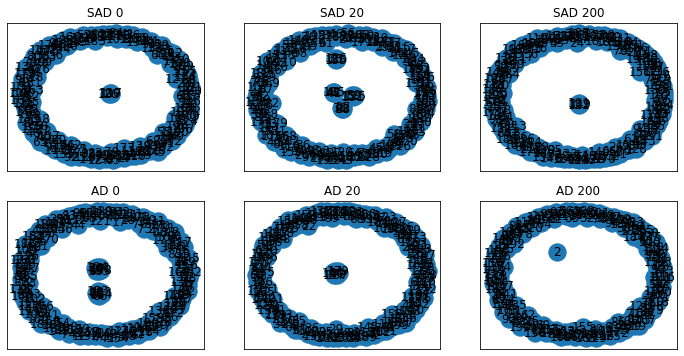

In [6]:
fig = plt.figure(figsize=(12,6))

for i,t in enumerate([0,20,200]):
    plt.subplot(2,3,i+1);
    nx.draw_networkx(SadTG[t]);
    plt.title('SAD '+str(t))
for i,t in enumerate([0,20,200]):
    plt.subplot(2,3,3+i+1);
    nx.draw_networkx(AdTG[t]);
    plt.title('AD '+str(t))

if you pass a list of length two as k=[k0,k1], then the code will assume that the distribution of 
the simplex sizes is a normal distribution with mean km0 and std k1.

In [7]:
SadTGa = {}
AdTGa = {} 
sigmas = np.linspace(0,0.5,5); #here im passing the coefficient of variation as sigma
for sigma in sigmas:
    SadTG,fh = sad.temporal_graph_creation(n,T,[k,k*sigma],act,mode='simplicial',returnhist=True);
    SadTGa[sigma] = sad.aggregate_graph(SadTG,Tagg)
    tot = []
    for t in fh:
        tot.extend(map(len,fh[t]))
    krenorm = int(round(sad.invert_k(np.mean(list(map(lambda x: x*(x-1)/2, tot))))))
    print(sigma, krenorm)
    AdTG = sad.temporal_graph_creation(n,T,krenorm,act,mode='network')
    AdTGa[sigma] = sad.aggregate_graph(AdTG,Tagg)

0.0 4
0.125 4
0.25 4
0.375 4
0.5 4


/usr/lib/python3/dist-packages/ipykernel_launcher.py:31: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


AttributeError: 'NodeView' object has no attribute 'remove'

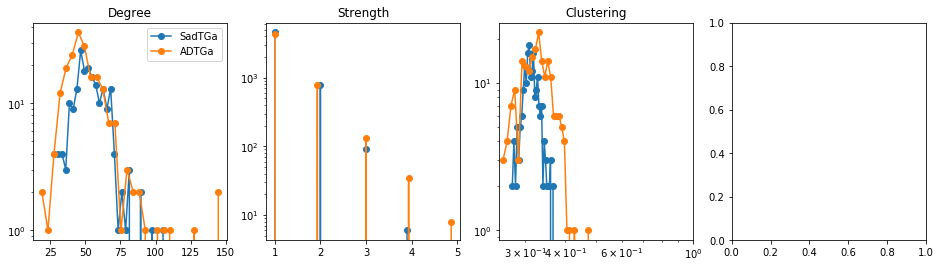

In [8]:
pl = 4 
for sigma in sigmas:
    fig = plt.figure(figsize=(16,4))
    plt.subplot(1,pl,1)
    aa, bb = np.histogram(list(dict(SadTGa[sigma].degree()).values()), 30)
    plt.plot(bb[:-1],aa,'o-',label='SadTGa')
    aa, bb = np.histogram(list(dict(AdTGa[sigma].degree()).values()), 30)
    plt.plot(bb[:-1],aa,'o-',label='ADTGa')
    plt.legend(loc=0)
#    plt.xscale('log')
    plt.yscale('log') 
    plt.title('Degree')

    plt.subplot(1,pl,2)
    aa, bb = np.histogram(list(nx.get_edge_attributes(SadTGa[sigma],'weight').values()), 30)
    plt.plot(bb[:-1],aa,'o-')
    aa, bb = np.histogram(list(nx.get_edge_attributes(AdTGa[sigma],'weight').values()), 30)
    plt.plot(bb[:-1],aa,'o-')
#    plt.xscale('log')
    plt.yscale('log') 
    plt.title('Strength')

    plt.subplot(1,pl,3)
    aa, bb = np.histogram(list(nx.clustering(SadTGa[sigma]).values()), 30)
    plt.plot(bb[:-1],aa,'o-')
    aa, bb = np.histogram(list(nx.clustering(AdTGa[sigma]).values()), 30)
    plt.plot(bb[:-1],aa,'o-')
    plt.xscale('log')
    plt.yscale('log') 
    plt.title('Clustering')
    plt.xlim(0,1)

    plt.subplot(1,pl,4)
    coreness, layerness = sad.onion_decomposition(SadTGa[sigma])
    aa, bb = np.histogram(list(layerness.values()), range(50), normed=True)
    plt.plot(bb[:-1],aa,'o-')
    coreness, layerness = sad.onion_decomposition(AdTGa[sigma])
    aa, bb = np.histogram(list(layerness.values()), range(50), normed=True)
    plt.plot(bb[:-1],aa,'o-')
    plt.title('Layer number')

    plt.tight_layout()

In [ ]:
SadTGa[sigma].degree()

if you pass a list of length n as $k=[s0,s1,....s_{n-1}]$, then the code will take that list and assign that size as the size of the simplex (in case the node activates).   
However, the way the code is written now, you have to use the instant graph creation functions directly. 

In [ ]:
vertex_dict = {}
kk = np.random.randint(2,10,size=n);
for nn in range(n):
    vertex_dict[nn] = sad.simplex_vertex(n,act[n]);
G, h = sad.memoryless_instant_graph(vertex_dict,kk,mode='simplicial')
G.number_of_edges()

In [ ]:
nx.draw_networkx(G)

# Exercise

- try visualizing with the previous drawing code
- measure simplicial degrees